In [1]:
#!pip install xgboost


# Basic Imports

In [2]:
import pandas as pd
import numpy as np

# For charts
import matplotlib.pyplot as plt
import seaborn as sns

# Opening a file

In [3]:
file_path = 'marketing_data.csv'
dict_path = 'marketing_data_dictionary.csv'

# Import the dataset
df = pd.read_csv(file_path)
dict = pd.read_csv(dict_path)

# Strip leading and trailing spaces from column names
df.columns = df.columns.str.strip()

# Some basic functionality

This is all to look at your stuff, get a base understanding

`df`

`df['col name']` , `df['col name', 'col2 name']`
`df.iloc[x:y:z]` x = start, y = end , z = every zth row (x+z+z+z+... until (x+z)>y ) 

`df.head()`

`df.tail()`

`df.shape`

`df.info()`

`df.describe()`

`df.isnull().sum())`       

`df['Income'].isnull()` , `df[df['Income'].isnull()]`

`df.drop(['col1', 'col2', 'col3'], axis = 1, inplace = True)`   # Dropping columns you dont want, inplace = true means it changes the df 

`a = df.drop(['col1', 'col2', 'col3'], axis = 1)`  # ^ This is the alternative, you make a new variable to hold the df without the columns

# Gotta fix missing values

Drop rows with missing values
`df.dropna(inplace=True)`

Replace missing values in 'Income' with the mean of the column

`df['Income'].fillna(df['Income'].mean(), inplace=True)`

In [4]:
df['Income'] = df['Income'].fillna(df['Income'].mean())

# You'd want to split numericals & categoricals

Some stuff doesent work for both numericals & categoricals, so this is how u can split them

In [5]:
# Select numerical columns (integers and floats)
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Select categorical columns (object and potentially 'category' dtypes if you've converted any)
categorical_df = df.select_dtypes(include=['object', 'category'])

In [6]:
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Income               2240 non-null   float64
 3   Kidhome              2240 non-null   int64  
 4   Teenhome             2240 non-null   int64  
 5   Recency              2240 non-null   int64  
 6   MntWines             2240 non-null   int64  
 7   MntFruits            2240 non-null   int64  
 8   MntMeatProducts      2240 non-null   int64  
 9   MntFishProducts      2240 non-null   int64  
 10  MntSweetProducts     2240 non-null   int64  
 11  MntGoldProds         2240 non-null   int64  
 12  NumDealsPurchases    2240 non-null   int64  
 13  NumWebPurchases      2240 non-null   int64  
 14  NumCatalogPurchases  2240 non-null   int64  
 15  NumStorePurchases    2240 non-null   i

In [7]:
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Education       2240 non-null   object
 1   Marital_Status  2240 non-null   object
 2   Dt_Customer     2240 non-null   object
 3   Country         2240 non-null   object
dtypes: object(4)
memory usage: 70.1+ KB


# Then can kinda do whatever

In [8]:
# Dropping a column:
categorical_df = categorical_df.drop(columns='Dt_Customer')
df = df.drop(columns='Dt_Customer')

# Gonna create a few functions, can grab these for future use

Defining functions here, scroll down after all the functions in order to see some use.

In [9]:
def visualize_numerical(df):
    for column in df.columns:
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))
        
        # Histogram
        sns.histplot(df[column], bins=30, ax=ax[0], kde=True)
        ax[0].set_title(f'Histogram of {column}')
        
        # Boxplot
        sns.boxplot(x=df[column], ax=ax[1])
        ax[1].set_title(f'Boxplot of {column}')
        
        plt.tight_layout()
        plt.show()

In [10]:
def visualize_categorical(df):
    for column in df.columns:
        plt.figure(figsize=(10, 4))
        
        # Bar chart
        sns.countplot(y=df[column], order = df[column].value_counts().index)
        plt.title(f'Distribution of {column}')
        plt.tight_layout()
        plt.show()

In [11]:
def plot_normalized_distribution_by_target(df, target_column, diff_threshold=0):
    """
    Generate bar plots for each categorical column in the DataFrame, excluding the target column.
    Plots are normalized with respect to the target column, highlighting distributions where
    the difference exceeds a specified threshold.
    
    Parameters:
    - df: DataFrame containing the data.
    - target_column: The name of the target column to normalize against and exclude from plotting.
    - diff_threshold: The percentage difference threshold for highlighting distributions.
    """
    # Select categorical columns, excluding the target column
    categorical_cols = df.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        # Normalizing counts
        x, y = col, target_column
        df_normalized = df.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()

        # Assuming binary target column with numeric values, convert them to str for visualization
        df_normalized[y] = df_normalized[y].astype(str)
        
        # Plotting
        plt.figure(figsize=(10,4))
        p = sns.barplot(x=x, y='percent', hue=y, data=df_normalized)
        
        # Add labels to the plot
        for rect in p.patches:
            height = rect.get_height()
            p.text(rect.get_x() + rect.get_width() / 2., height, f'{round(height,2)}%', 
                    ha='center', va='bottom')

        plt.title(f'Normalized Distribution of {col} by {target_column}')
        plt.xticks(rotation=90)
        plt.show()

In [12]:
def plot_correlation_heatmap(df):
    """
    Generates a heatmap visualizing the correlation matrix of numerical columns in the DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    """
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Calculate correlation matrix
    corr_matrix = df[numerical_cols].corr()
    
    # Plot heatmap
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()


# Now lets see the functions above

In [13]:
#visualize_numerical(numerical_df)

#visualize_categorical(categorical_df)


#plot_normalized_distribution_by_target(df, 'Response')

In [14]:
#plot_correlation_heatmap(df)
#sns.clustermap(numerical_df.corr(), annot=True, cmap='coolwarm', figsize=(15,15))

# Some machine learning related stuff 

If you have something you're predicting, ie. response to a campaign being 0 (no) or 1 (yes), some stuff you can do

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb

## Logistic Regression Model Stuff

### Functions

I think the coef chart at the end of this section may be usable / helpful for many situation

In [16]:
def create_basic_logistic_regression_auto_features(df, target_feature, test_size=0.2, random_state=0, max_iter=500):
    """
    Creates a logistic regression model based on the provided DataFrame and target feature.
    Automatically selects predictive features as all columns except the target.
    Splits the data, scales numeric features, and fits the logistic regression model.
    
    Parameters:
    - df: DataFrame containing the data.
    - target_feature: Name of the target feature column.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator for reproducible output.
    - max_iter: Maximum number of iterations taken for the solvers to converge.
    
    Returns:
    - model: Trained logistic regression model.
    - X_train, X_test, y_train, y_test: Training and testing datasets.
    """
    # Automatically define predictive features as all columns except the target feature
    predictive_features = [col for col in df.columns if col != target_feature]
    
    # Divide data into features and target
    X = df[predictive_features]
    y = df[target_feature]
    
    # Divide data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Select only numeric columns for scaling
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    
    # Initialize and fit the StandardScaler on numeric columns
    scaler = StandardScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    # Initialize and fit the logistic regression model on scaled numeric features
    model = LogisticRegression(max_iter=max_iter)
    model.fit(X_train[numeric_cols], y_train)
    
    return model, X_train, X_test, y_train, y_test

In [17]:
def plot_confusion_matrix(model, X_test, y_test):
    """
    Generates and plots a confusion matrix for the given model and test data.
    
    Parameters:
    - model: The trained machine learning model.
    - X_test: The test features.
    - y_test: The true labels for the test data.
    """
    # Predict classes using the model
    y_pred = model.predict(X_test)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

In [18]:
def plot_logistic_regression_feature_importance(model, feature_names, top_n=30):
    """
    Plots the top N feature importances for a trained logistic regression model.
    
    Parameters:
    - model: The trained logistic regression model.
    - feature_names: The names of the features used to train the model.
    - top_n: The number of top features to display.
    """
    # Get importance coefficients from the model
    importance = model.coef_[0]

    # Create a DataFrame of features and their importance
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

    # Take absolute value of coefficients for ranking
    feature_importance['abs_importance'] = feature_importance['Importance'].abs()

    # Sort by absolute importance and select top N features
    top_features = feature_importance.sort_values('abs_importance', ascending=False).iloc[:top_n]

    # Sort the top_features DataFrame in descending order by Importance for the plot
    top_features = top_features.sort_values('Importance', ascending=False)

    # Color based on positive or negative coefficient
    colors = ['green' if x > 0 else 'red' for x in top_features['Importance']]

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(top_features['Feature'], top_features['Importance'], color=colors)
    plt.xticks(rotation=90)  # Changed to 90 for better label readability
    plt.title("Top {} Feature Importance".format(top_n))
    plt.ylabel("Coefficient")

    # Find the position of the first negative coefficient and draw a line
    first_negative = np.where(top_features['Importance']<0)[0]
    if len(first_negative) > 0:
        plt.axvline(x=first_negative[0]-0.5, color='black', linestyle='--')

    plt.show()

In [19]:
def plot_vif_for_dataframe(df, target_feature, threshold=10):
    """
    Automatically selects predictive features as all columns except the target from the given DataFrame, 
    calculates VIF for each feature, and plots the features with VIF values below the specified threshold.
    
    Parameters:
    - df: DataFrame containing the data and the target feature.
    - target_feature: Name of the target feature column to exclude from VIF calculation.
    - threshold: The VIF value threshold for filtering features to plot.
    """
    # Exclude target feature and ensure only numeric features are considered
    X = df[[col for col in df.columns if col != target_feature and df[col].dtype != 'object']]
    
    # Initialize the VIF DataFrame
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    
    # Calculate VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    
    # Filter features based on the threshold
    filtered_vif = vif_data[vif_data['VIF'] <= threshold]
    
    # Sort the filtered VIF data
    final_vif = filtered_vif.sort_values('VIF').copy()
    
    # Assign colors based on VIF values
    final_vif['color'] = ['green' if vif <= 2 else 'orange' if vif <= 5 else 'red' for vif in final_vif['VIF']]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(final_vif['feature'], final_vif['VIF'], color=final_vif['color'])
    plt.xticks(rotation='vertical')
    plt.title(f"Features with VIF Value Below {threshold}")
    plt.ylabel("VIF")
    plt.show()

### Examples of the ML functions above

In [20]:
model, X_train, X_test, y_train, y_test = create_basic_logistic_regression_auto_features(df=numerical_df, target_feature='Response') # makes logreg model

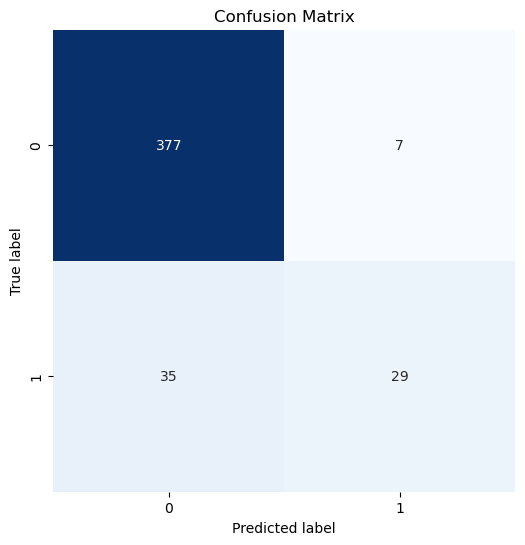

In [21]:
plot_confusion_matrix(model, X_test, y_test)              #shows model predict to real target. if this looks okay, then u can use it. if its scuffed, gotta fix

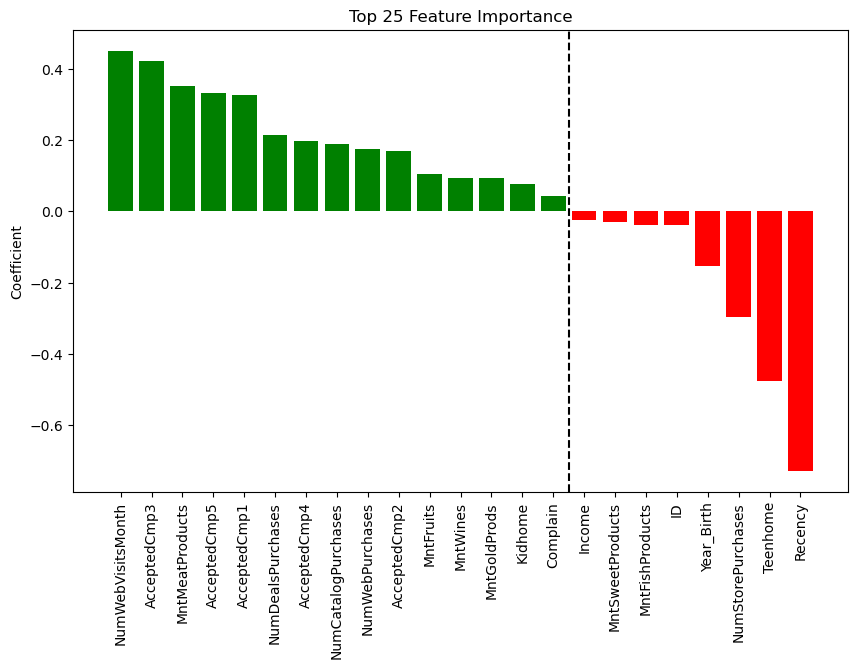

In [22]:
plot_logistic_regression_feature_importance(model, X_train.columns, top_n=25)                                  #shows n features w/ highest

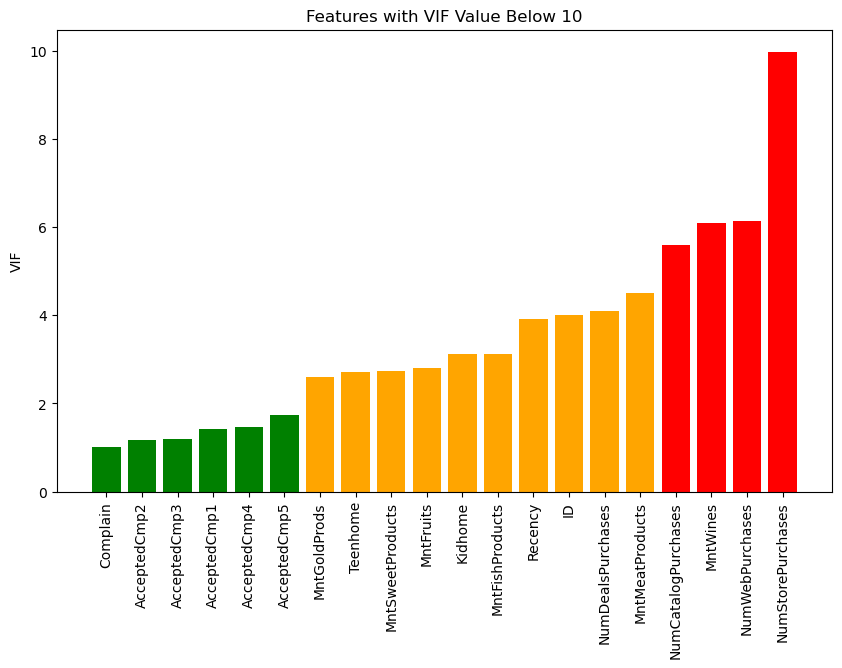

In [23]:
plot_vif_for_dataframe(df, target_feature='Response')

The bar chart above visualizes the VIF values of the selected features, color-coded for ease of interpretation:

**Green**: VIF <= 2, these features exhibit low multicollinearity and are solid candidates for inclusion in our model.

**Orange**: 2 < VIF <= 5, these features have moderate multicollinearity but can still be reasonably included in our model.

**Red**: 5 < VIF <= 10, these features show high multicollinearity. Their inclusion in the model could be considered, however, they could also be excluded if constraints such as model complexity or overfitting become an issue.

##  Gonna apply some changes to the df, this will likely produce better results:

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


### Functions

In [25]:
def preprocess_and_balance_with_visuals(df, target_variable, test_size=0.2, random_state=0):
    """
    Splits data into training and test sets, applies standard scaling, 
    and uses SMOTE to balance the target variable in the training set. Generates
    visuals for the target variable distribution before and after SMOTE.
    
    Parameters:
    - df: DataFrame containing the features and the target variable.
    - target_variable: The name of the target variable column.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: The seed used by the random number generator for reproducible results.
    
    Returns:
    - X_train_res, y_train_res: Resampled training data.
    - X_test, y_test: Test data.
    """
    # Separate features and target variable
    X = df.drop(target_variable, axis=1)
    y = df[target_variable]
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Visualize the original distribution of the target variable
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_train)
    plt.title("Original Distribution of Target ('old')")
    plt.show()
    
    # Define and apply the scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and apply SMOTE
    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
    
    # Visualize the distribution of the target variable after SMOTE
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_train_res)
    plt.title("Distribution of Target After SMOTE ('new')")
    plt.show()
    
    return X_train_res, y_train_res, X_test_scaled, y_test

# Example usage:
# X_train_res, y_train_res, X_test, y_test = preprocess_and_balance_with_visuals(df=my_df, target_variable='Response')

In [26]:
def train_model_after_smote_vif(X_train_res, y_train_res, X_test_scaled, y_test, feature_names, vif_threshold=5, max_iter=500, random_state=0):
    """
    Filters features based on VIF threshold after applying SMOTE and trains a logistic regression model.
    
    Parameters:
    - X_train_res, y_train_res: The resampled training data after applying SMOTE.
    - X_test_scaled, y_test: Scaled test data and test labels.
    - feature_names: The names of the original features before SMOTE and scaling.
    - vif_threshold: The threshold for filtering features based on VIF.
    - max_iter: Maximum iterations for the logistic regression solver.
    - random_state: Seed for reproducibility.
    
    Returns:
    - model: The trained logistic regression model.
    - features_below_threshold: The names of the features that were used to train the model after VIF filtering.
    """
    # Convert the resampled training data back to a DataFrame for VIF calculation
    X_train_res_df = pd.DataFrame(X_train_res, columns=feature_names)
    
    # Calculate VIF and filter features
    vif_data = pd.DataFrame({
        'feature': X_train_res_df.columns,
        'VIF': [variance_inflation_factor(X_train_res_df.values, i) 
                for i in range(X_train_res_df.shape[1])]
    })
    features_below_threshold = vif_data[vif_data['VIF'] < vif_threshold]['feature'].tolist()
    
    # Filter the training and test sets based on VIF-selected features
    X_train_filtered = X_train_res_df[features_below_threshold].values
    # Ensure correct indexing for filtered features in X_test_scaled
    filtered_feature_indices = [feature_names.index(feat) for feat in features_below_threshold]
    X_test_filtered = X_test_scaled[:, filtered_feature_indices]
    
    # Train the logistic regression model
    model = LogisticRegression(max_iter=max_iter, random_state=random_state)
    model.fit(X_train_filtered, y_train_res)
    
    # Optionally, evaluate the model
    y_pred = model.predict(X_test_filtered)
    print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    # Return both the model and the names of the filtered features
    return model, features_below_threshold


### Doing the stuff

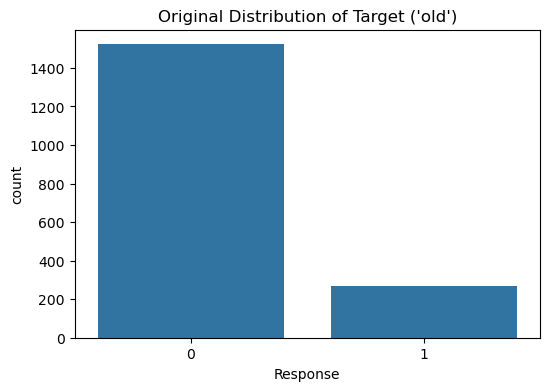

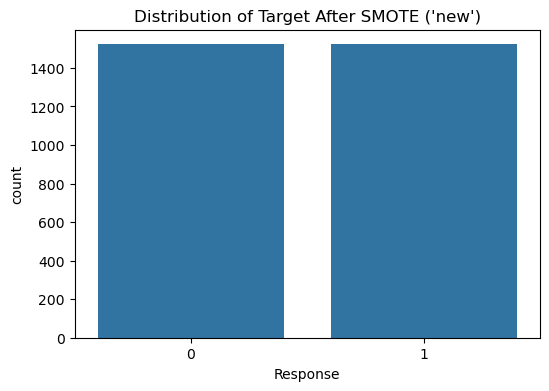

Accuracy on Test Set: 0.84375
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       384
           1       0.47      0.88      0.62        64

    accuracy                           0.84       448
   macro avg       0.73      0.86      0.76       448
weighted avg       0.90      0.84      0.86       448



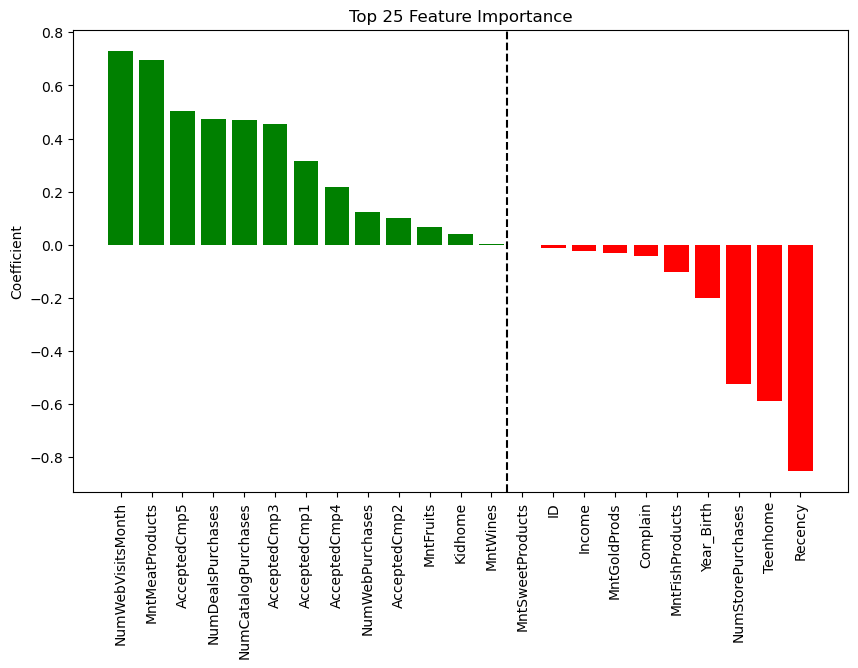

In [27]:
# Workflow example:
# 1. Preprocess and balance data
X_train_res, y_train_res, X_test_scaled, y_test = preprocess_and_balance_with_visuals(numerical_df, 'Response')                                    # Change 'Response' to target variable

# 2. Train model after SMOTE and VIF filtering
model_vif, filtered_feature_names = train_model_after_smote_vif(
    X_train_res, 
    y_train_res, 
    X_test_scaled, 
    y_test, 
    list(numerical_df.drop('Response', axis=1).columns),                                                                                         # Change 'Response' to target variable
    vif_threshold=5
)


# 3
plot_logistic_regression_feature_importance(model_vif, filtered_feature_names, top_n=25)                                                           #Change top_n

### This is prob a better performing model, but not sure how this can help for when your task isn't to just make a model

#### Functions

In [28]:
import xgboost as xgb
import shap

In [29]:
def train_xgboost_model(X_train_res, y_train_res, max_depth=3, n_estimators=100, learning_rate=0.1, random_state=0):
    """
    Trains an XGBoost classifier on the provided training data.

    Parameters:
    - X_train_res: Resampled training features (after applying SMOTE).
    - y_train_res: Resampled training targets (after applying SMOTE).
    - max_depth: Maximum tree depth for base learners.
    - n_estimators: Number of gradient boosted trees.
    - learning_rate: Boosting learning rate (xgb's "eta").
    - random_state: Seed used by the random number generator.
    
    Returns:
    - model: Trained XGBoost model.
    """
    model = xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_res, y_train_res)
    
    return model

In [30]:
def plot_xgboost_feature_importance(model, feature_names, top_n=30):
    """
    Plots the top N feature importances for a trained XGBoost model.
    
    Parameters:
    - model: The trained XGBoost model.
    - feature_names: The names of the features used to train the model.
    - top_n: The number of top features to display.
    """
    # Get feature importances from the model
    importance = model.feature_importances_
    
    # Create a DataFrame of features and their importance
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    
    # Sort by importance and select top N features
    top_features = feature_importance.sort_values('Importance', ascending=False).iloc[:top_n]
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xticks(rotation=90)  # For better label readability
    plt.title(f"Top {top_n} Feature Importance in XGBoost Model")
    plt.ylabel("Importance")
    
    plt.show()

#### Using Functions

In [31]:
# Train XGBoost model with SMOTE balanced data
model_xgb = train_xgboost_model(X_train_res, y_train_res)

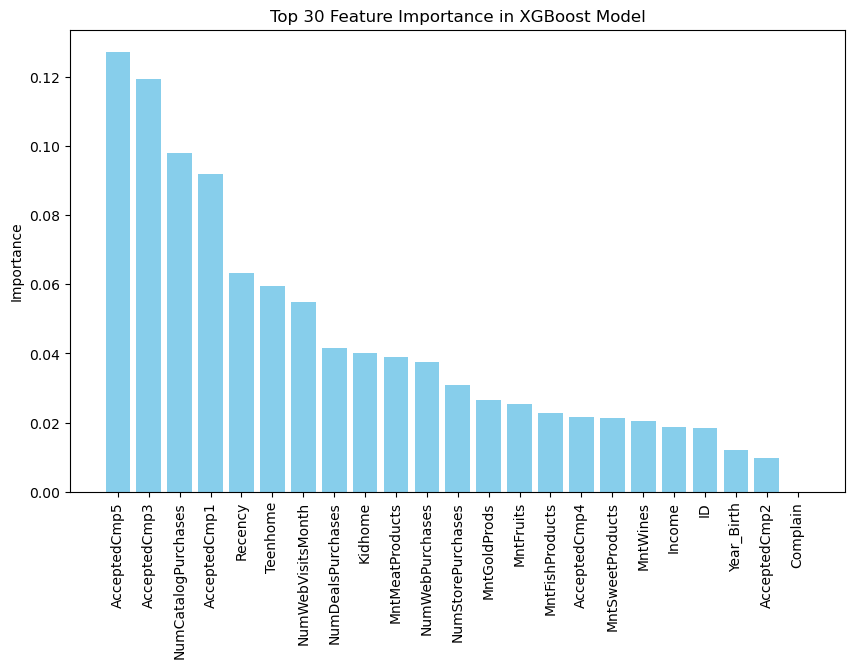

In [32]:
# Assuming 'model' is your trained XGBoost model and 'X_train' is the training dataset
feature_names = X_train.columns.tolist()  # or however you have stored your feature names
plot_xgboost_feature_importance(model_xgb, feature_names)

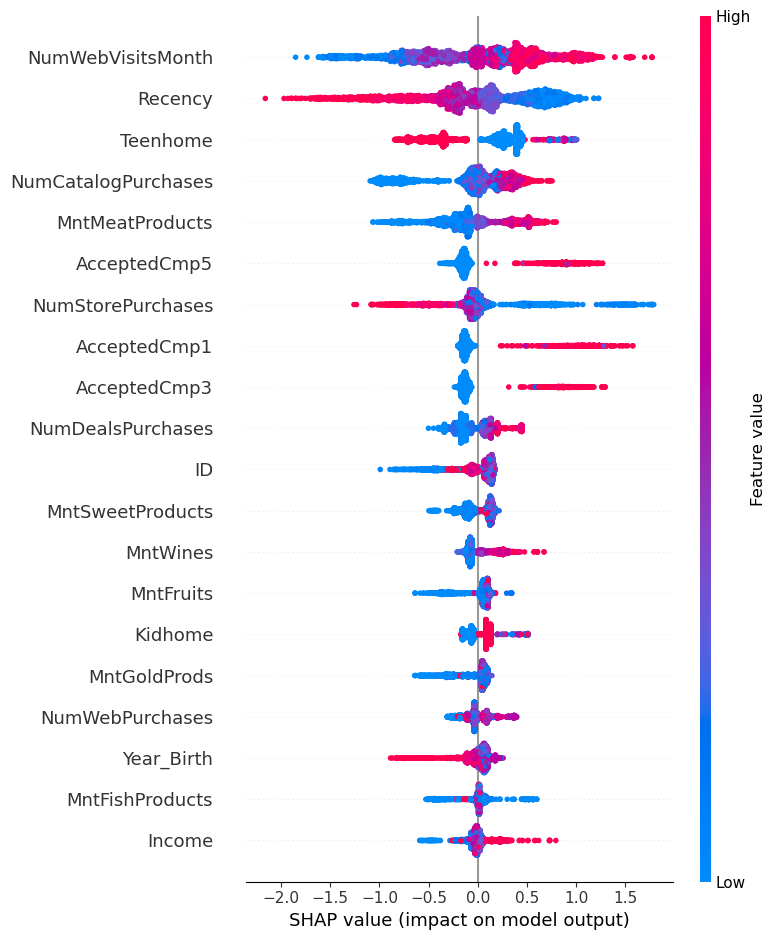

In [33]:
shap_values = shap.TreeExplainer(model_xgb).shap_values(X_train_res)
shap.summary_plot(shap_values, X_train_res, feature_names=feature_names)